In [1]:
# couple issues that I've seen. Single images are not enough to allow a classification
# we might need 24 images per day to get a daily average
# other problems might be the time of day? perhaps dark images are not useful?

In [46]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import src.tools as tools
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
stations = ['ParkersBrook','BrownsBrook','GrantPoole']
station_name = stations[2]

wd = f'/datadrive/stream_data/training/{station_name}'
bins = ['train', 'val', 'test']
data ={}
for b in bins:
    datatable_name = f'{wd}/{b}_table.csv'
    data[b] = pd.read_csv(datatable_name)

In [48]:
#lets get the y data
train_dataset = tools.create_regression_data_from_dataframe(data['train'])
val_dataset = tools.create_regression_data_from_dataframe(data['val'])
#test_dataset = tools.create_regression_data_from_dataframe(data['test'])

In [49]:
#input_shape = Xtrain[0].shape
input_shape = (480, 640, 3)

In [50]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
num_classes = 1

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [51]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

In [52]:
epochs = 30
batch_size = 10
history = model.fit(train_dataset.shuffle(20).padded_batch(batch_size),\
                    validation_data=val_dataset.batch(batch_size),\
                    epochs=epochs)

Epoch 1/30
56/56 [==============================] - 9s 154ms/step - loss: 61.6030 - r_square: -334.1776 - val_loss: 0.1894 - val_r_square: 0.0785
Epoch 2/30
56/56 [==============================] - 9s 152ms/step - loss: 0.1335 - r_square: 0.2734 - val_loss: 0.1083 - val_r_square: 0.4728
Epoch 3/30
56/56 [==============================] - 8s 152ms/step - loss: 0.0693 - r_square: 0.6229 - val_loss: 0.0958 - val_r_square: 0.5341
Epoch 4/30
56/56 [==============================] - 9s 152ms/step - loss: 0.0411 - r_square: 0.7762 - val_loss: 0.0717 - val_r_square: 0.6512
Epoch 5/30
56/56 [==============================] - 8s 150ms/step - loss: 0.0248 - r_square: 0.8652 - val_loss: 0.0622 - val_r_square: 0.6974
Epoch 6/30
56/56 [==============================] - 9s 153ms/step - loss: 0.0191 - r_square: 0.8960 - val_loss: 0.0525 - val_r_square: 0.7445
Epoch 7/30
56/56 [==============================] - 9s 152ms/step - loss: 0.0157 - r_square: 0.9145 - val_loss: 0.0467 - val_r_square: 0.7726
Ep

In [53]:
modelname = 'simple_cnn_regression'
pd.DataFrame(history.history).to_csv(f'/datadrive/model/{station_name}/{modelname}/history/{modelname}.csv')
model.save(f'/datadrive/model/{station_name}/{modelname}/weights/{modelname}.h5') 
jsonfile = f'/datadrive/model/{station_name}/{modelname}/weights/{modelname}.json'
model_json = model.to_json()
with open(jsonfile, "w") as json_file:
    json_file.write(model_json)

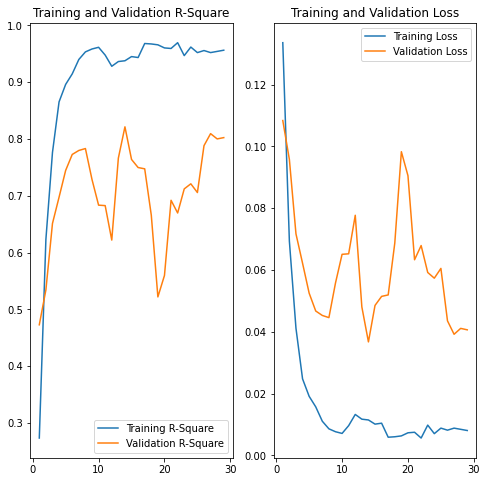

In [54]:
acc = history.history['r_square'][1:]
val_acc = history.history['val_r_square'][1:]

loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs_range = range(epochs)[1:]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training R-Square')
plt.plot(epochs_range, val_acc, label='Validation R-Square')
plt.legend(loc='lower right')
plt.title('Training and Validation R-Square')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model.evaluate(test_dataset, batch_size=28)

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [480, 640, 3]


In [18]:
test = test_dataset.take(1)

In [20]:
for im, label in test:
    print(im, label)

tf.Tensor(
[[[0.26666668 0.34117648 0.23137255]
  [0.22352941 0.29803923 0.18039216]
  [0.3529412  0.41960785 0.29411766]
  ...
  [0.08627451 0.10980392 0.07058824]
  [0.1882353  0.21176471 0.17254902]
  [0.24313726 0.26666668 0.22745098]]

 [[0.25490198 0.32941177 0.21960784]
  [0.16862746 0.24313726 0.1254902 ]
  [0.24705882 0.30980393 0.19607843]
  ...
  [0.09411765 0.11764706 0.07843138]
  [0.15294118 0.1764706  0.13725491]
  [0.33333334 0.35686275 0.31764707]]

 [[0.23921569 0.3137255  0.20392157]
  [0.27450982 0.34901962 0.23137255]
  [0.2901961  0.3529412  0.23921569]
  ...
  [0.16862746 0.19215687 0.14509805]
  [0.41960785 0.44313726 0.40392157]
  [0.44313726 0.46666667 0.42745098]]

 ...

 [[0.07450981 0.07450981 0.07450981]
  [0.05490196 0.05490196 0.05490196]
  [0.09411765 0.09411765 0.09411765]
  ...
  [0.11764706 0.11764706 0.11764706]
  [0.02352941 0.02352941 0.02352941]
  [0.1254902  0.1254902  0.1254902 ]]

 [[0.09803922 0.09803922 0.09803922]
  [0.10980392 0.10980392 0